# U-net

Segmentación semántica

<img src="./misc/u-net-architecture.png" width="75%">

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils
from torchvision.io import read_file, decode_jpeg, decode_png, ImageReadMode
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchvision.io import read_image

In [2]:
# DATASET
import os

# read dataset for u-net
class Dataset(Dataset):
    def __init__(self, data_dir, label_dir):
        self.data_dir = data_dir
        self.label_dir = label_dir
        self.files = [os.path.splitext(f)[0] for f in os.listdir(data_dir)]
        self.transform = T.Resize((512, 512))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_name = self.files[idx]
        # read image
        image = read_image(os.path.join(self.data_dir, file_name + ".png"), mode=ImageReadMode.RGB)
        
        # read mask
        mask = read_image(os.path.join(self.label_dir, file_name + ".png"), mode=ImageReadMode.GRAY)
        
        # resize
        image = self.transform(image)
        mask = self.transform(mask)
        
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)
        
        image = image / 255.0
        mask /= 255.0
        mask = torch.round(mask)

        return image, mask
        

        
ds = Dataset("test/", "labels/")
ds_loader = DataLoader(ds, batch_size=4)

In [3]:
import torch
import torch.nn as nn

""" Convolutional block:
    It follows a two 3x3 convolutional layer, each followed by a batch normalization and a relu activation.
"""
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

""" Encoder block:
    It consists of an conv_block followed by a max pooling.
    Here the number of filters doubles and the height and width half after every block.
"""
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

""" Decoder block:
    The decoder block begins with a transpose convolution, followed by a concatenation with the skip
    connection from the encoder block. Next comes the conv_block.
    Here the number filters decreases by half and the height and width doubles.
"""
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c, skip=True):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.skip = skip
        input_dimension = out_c+out_c if skip else out_c
        self.conv = conv_block(input_dimension, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        if self.skip:
            x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x


class build_unet(nn.Module):
    def __init__(self, f_start=64, skips=[True, True, True, True]):
        super().__init__()
        
        s = f_start

        """ Encoder """
        self.e1 = encoder_block(3, s)
        self.e2 = encoder_block(s, s*2)
        self.e3 = encoder_block(s*2, s*4)
        self.e4 = encoder_block(s*4, s*8)

        """ Bottleneck """
        self.b = conv_block(s*8, s*16)
        """ Decoder """
        self.d1 = decoder_block(s*16, s*8, skips[0])
        self.d2 = decoder_block(s*8, s*4, skips[1])
        self.d3 = decoder_block(s*4, s*2, skips[2])
        self.d4 = decoder_block(s*2, s, skips[3])

        """ Classifier """
        self.outputs = nn.Conv2d(s, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)

        return outputs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

inputs = torch.randn((2, 3, 512, 512)).to(device)
model = build_unet().to(device)
y = model(inputs)
print(y.shape)

torch.Size([2, 1, 512, 512])


### Modelo base


In [5]:
def train(model, n_epochs):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=1e-3, 
                                 weight_decay=1e-5)
    for epoch in range(n_epochs):
        for idx, (images, labels) in enumerate(ds_loader):
            # Forward pass
            outputs = model(images.to(device))
            loss = criterion(outputs, labels.to(device))
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print("Lote:", idx)

        print (f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')
    
train(model, n_epochs=200)


C:\Users\fabio\AppData\Local\Temp\ipykernel_20024\3170726975.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\fabio\AppData\Local\Temp\ipykernel_20024\3170726975.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Lote: 0
Epoch [1/200], Loss: 0.2060
Lote: 0
Epoch [2/200], Loss: 0.5380
Lote: 0
Epoch [3/200], Loss: 0.1867
Lote: 0
Epoch [4/200], Loss: 0.0891
Lote: 0
Epoch [5/200], Loss: 0.0743
Lote: 0
Epoch [6/200], Loss: 0.0622
Lote: 0
Epoch [7/200], Loss: 0.0590
Lote: 0
Epoch [8/200], Loss: 0.0531
Lote: 0
Epoch [9/200], Loss: 0.0517
Lote: 0
Epoch [10/200], Loss: 0.0478
Lote: 0
Epoch [11/200], Loss: 0.0468
Lote: 0
Epoch [12/200], Loss: 0.0460
Lote: 0
Epoch [13/200], Loss: 0.0424
Lote: 0
Epoch [14/200], Loss: 0.0406
Lote: 0
Epoch [15/200], Loss: 0.0417
Lote: 0
Epoch [16/200], Loss: 0.0402
Lote: 0
Epoch [17/200], Loss: 0.0384
Lote: 0
Epoch [18/200], Loss: 0.0353
Lote: 0
Epoch [19/200], Loss: 0.0315
Lote: 0
Epoch [20/200], Loss: 0.0301
Lote: 0
Epoch [21/200], Loss: 0.0257
Lote: 0
Epoch [22/200], Loss: 0.0228
Lote: 0
Epoch [23/200], Loss: 0.0308
Lote: 0
Epoch [24/200], Loss: 0.0309
Lote: 0
Epoch [25/200], Loss: 0.0312
Lote: 0
Epoch [26/200], Loss: 0.0273
Lote: 0
Epoch [27/200], Loss: 0.0236
Lote: 0
Ep

C:\Users\fabio\AppData\Local\Temp\ipykernel_20024\3170726975.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\fabio\AppData\Local\Temp\ipykernel_20024\3170726975.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


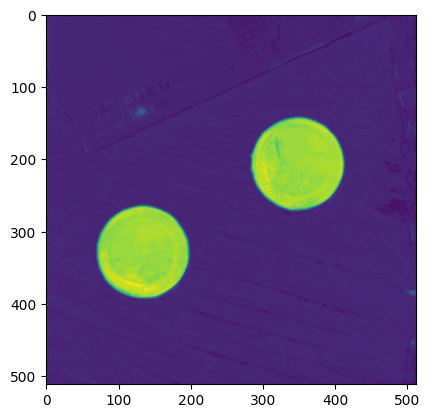

In [6]:
it = iter(ds_loader)
img, label = next(it)

model.eval()

ret = model(img.to(device))
plt.imshow(ret[1][0].detach().cpu().numpy())

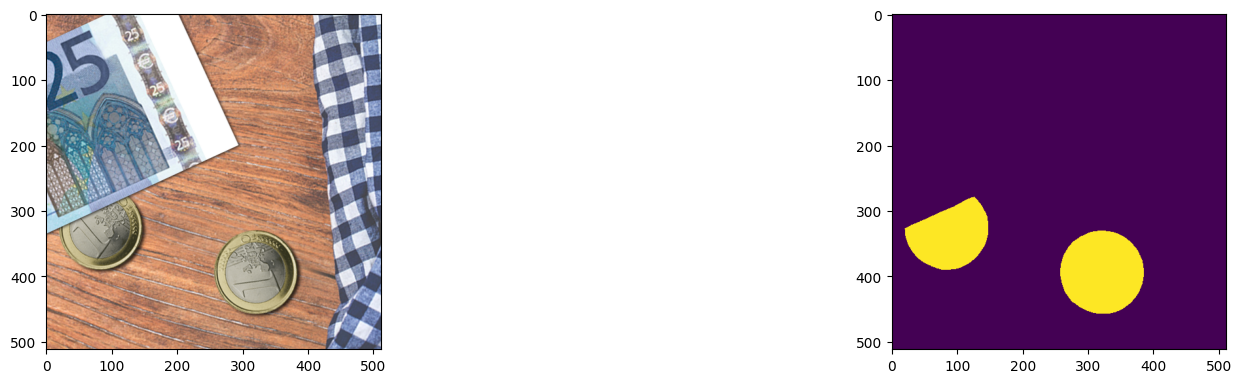

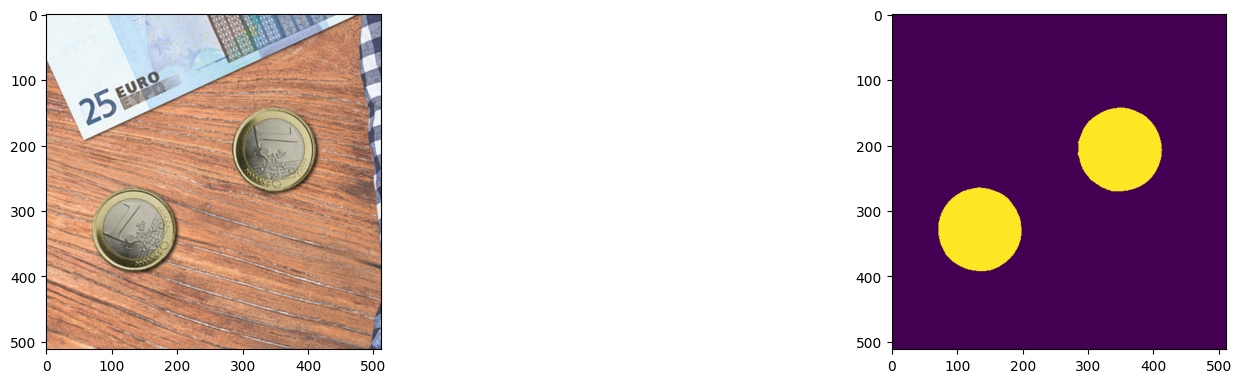

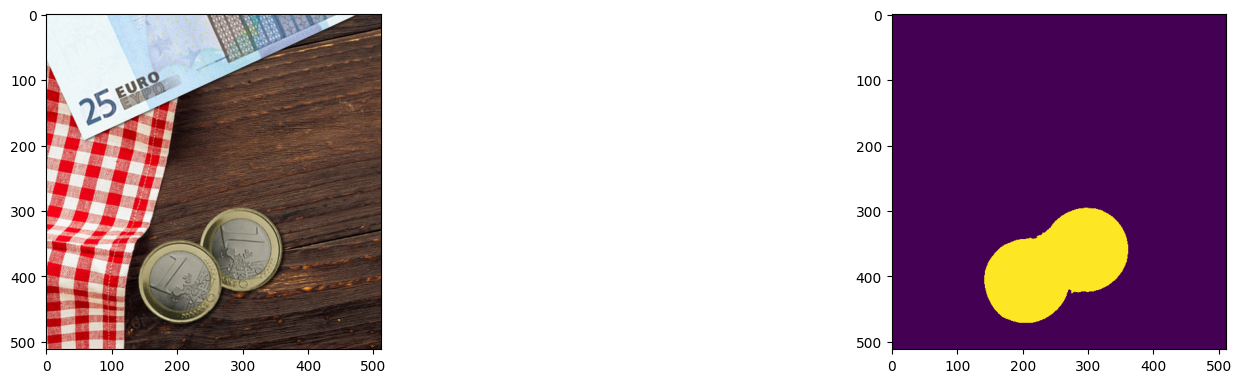

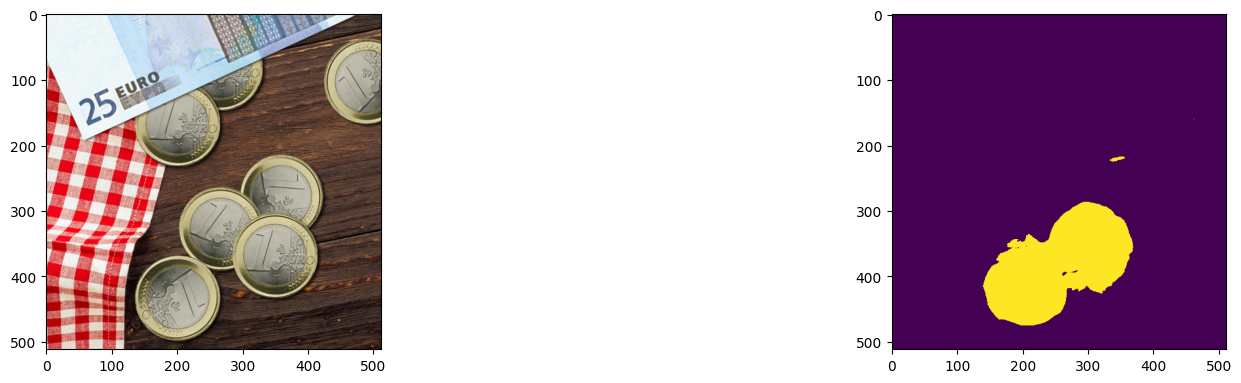

In [7]:

# Threshold the output
ret = torch.round(ret)

# Show a matrix of images of 4x2 
for i in range(4):
    # Size image
    plt.figure(figsize=(20, 20))
    plt.subplot(4, 2, 2*i+1)
    plt.imshow(img[i].permute(1, 2, 0).detach().cpu().numpy())
    plt.subplot(4, 2, 2*i+2)
    plt.imshow(ret[i][0].detach().cpu().numpy() )


In [5]:
def visualize_prediction(model, dataset_loader, n=4):
    model.eval()
    with torch.no_grad():
        images, masks = next(iter(dataset_loader))
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        
        for i in range(n):
            img = images[i].cpu().permute(1, 2, 0).numpy()
            mask = masks[i].cpu().squeeze().numpy()
            pred = outputs[i].cpu().squeeze().numpy()
            
            plt.figure(figsize=(12, 4))
            
            plt.subplot(1, 3, 1)
            plt.title("Imagen original")
            plt.imshow(img)
            plt.axis('off')
            
            plt.subplot(1, 3, 2)
            plt.title("Mascara real")
            plt.imshow(mask, cmap='gray')
            plt.axis('off')
            
            plt.subplot(1, 3, 3)
            plt.title("Prediccion modelo")
            plt.imshow(pred > 0.5, cmap='gray') 
            plt.axis('off')
            
            plt.suptitle(f'Ejemplo {i+1}')
            plt.show()

C:\Users\fabio\AppData\Local\Temp\ipykernel_20024\3170726975.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\fabio\AppData\Local\Temp\ipykernel_20024\3170726975.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


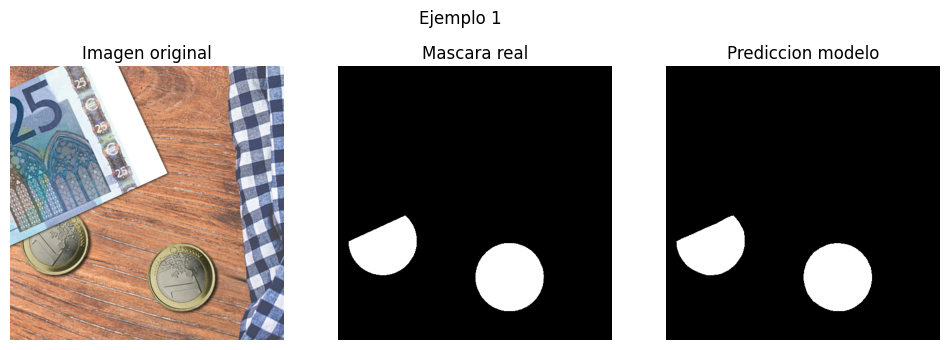

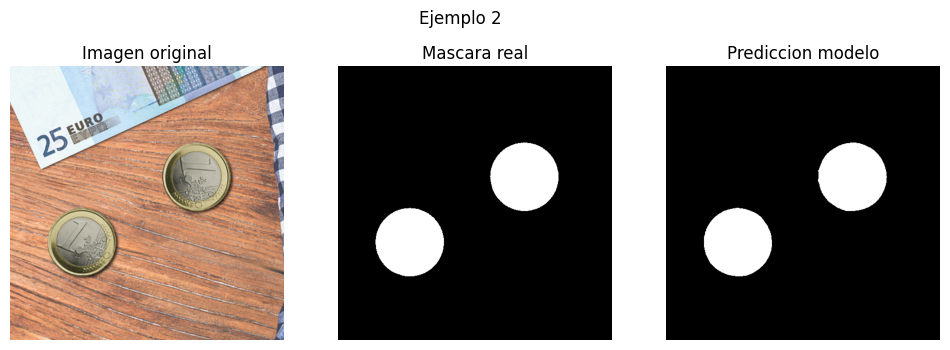

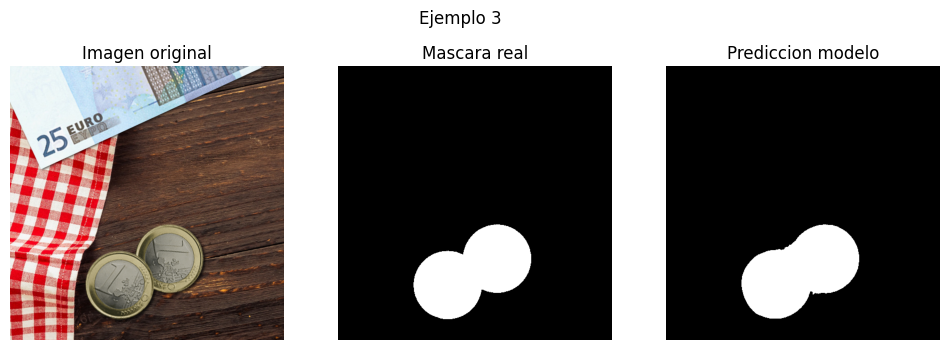

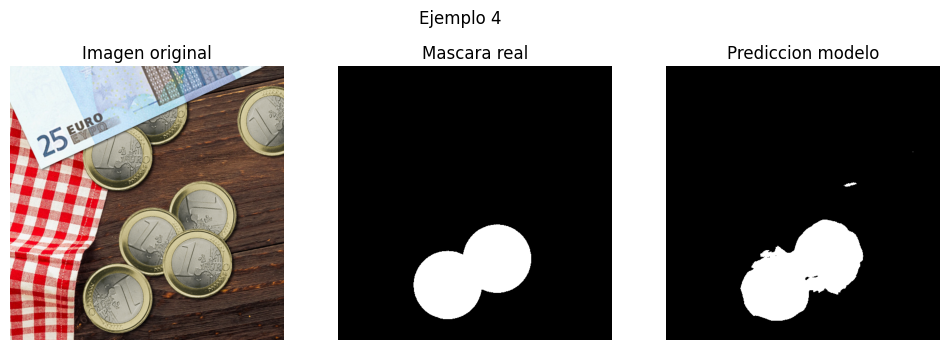

In [9]:
visualize_prediction(model, ds_loader)

In [6]:
def intersection_over_union(model, loader, device):
    model.eval()
    intersection = 0
    union = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float()
            # Calculamos intersección (donde ambos son 1)
            intersection += (preds * labels).sum()
            # Calculamos unión (donde alguno es 1)
            union += (preds + labels).clamp(0, 1).sum()
    
    iou = intersection / (union + 1e-6)
    return iou.item()

In [11]:
iou_score = intersection_over_union(model, ds_loader, device)
print(f"Puntuacion IoU del modelo actual: {iou_score:.4f}")

C:\Users\fabio\AppData\Local\Temp\ipykernel_20024\3170726975.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\fabio\AppData\Local\Temp\ipykernel_20024\3170726975.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Puntuacion IoU del modelo actual: 0.9604


In [12]:
torch.save(model.state_dict(), "model_unet_coins.pth")

In [13]:
#model = build_unet()
model.load_state_dict(torch.load("model_unet_coins.pth"))

<All keys matched successfully>

# Skip 1

In [7]:
ablated_1 = build_unet(f_start=64, skips=[False, True, True, True]).to(device)
train(ablated_1, n_epochs=100)

C:\Users\fabio\AppData\Local\Temp\ipykernel_18168\3170726975.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\fabio\AppData\Local\Temp\ipykernel_18168\3170726975.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Lote: 0
Epoch [1/100], Loss: 0.2065
Lote: 0
Epoch [2/100], Loss: 0.5217
Lote: 0
Epoch [3/100], Loss: 0.1594
Lote: 0
Epoch [4/100], Loss: 0.1053
Lote: 0
Epoch [5/100], Loss: 0.0742
Lote: 0
Epoch [6/100], Loss: 0.0719
Lote: 0
Epoch [7/100], Loss: 0.0652
Lote: 0
Epoch [8/100], Loss: 0.0554
Lote: 0
Epoch [9/100], Loss: 0.0523
Lote: 0
Epoch [10/100], Loss: 0.0525
Lote: 0
Epoch [11/100], Loss: 0.0505
Lote: 0
Epoch [12/100], Loss: 0.0469
Lote: 0
Epoch [13/100], Loss: 0.0440
Lote: 0
Epoch [14/100], Loss: 0.0420
Lote: 0
Epoch [15/100], Loss: 0.0415
Lote: 0
Epoch [16/100], Loss: 0.0414
Lote: 0
Epoch [17/100], Loss: 0.0400
Lote: 0
Epoch [18/100], Loss: 0.0385
Lote: 0
Epoch [19/100], Loss: 0.0375
Lote: 0
Epoch [20/100], Loss: 0.0374
Lote: 0
Epoch [21/100], Loss: 0.0374
Lote: 0
Epoch [22/100], Loss: 0.0371
Lote: 0
Epoch [23/100], Loss: 0.0363
Lote: 0
Epoch [24/100], Loss: 0.0355
Lote: 0
Epoch [25/100], Loss: 0.0350
Lote: 0
Epoch [26/100], Loss: 0.0347
Lote: 0
Epoch [27/100], Loss: 0.0346
Lote: 0
Ep

C:\Users\fabio\AppData\Local\Temp\ipykernel_18168\3170726975.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\fabio\AppData\Local\Temp\ipykernel_18168\3170726975.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


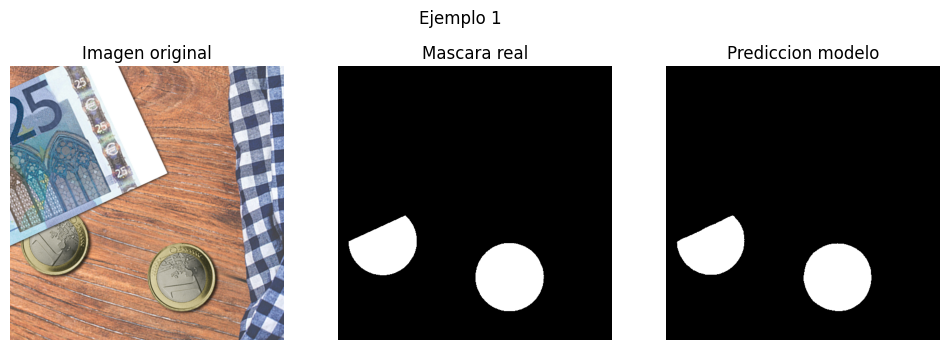

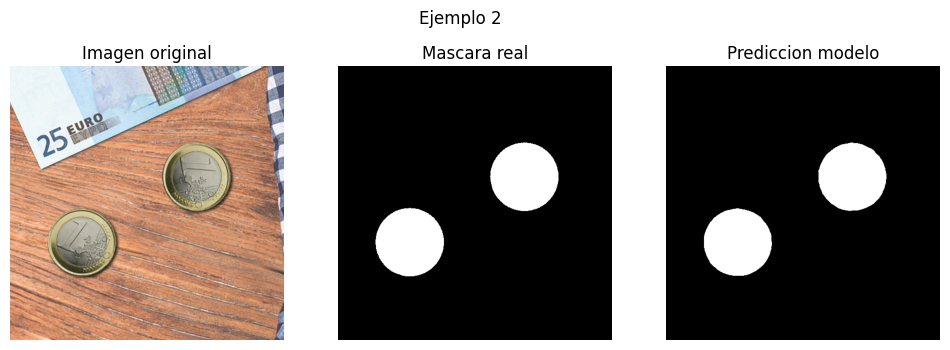

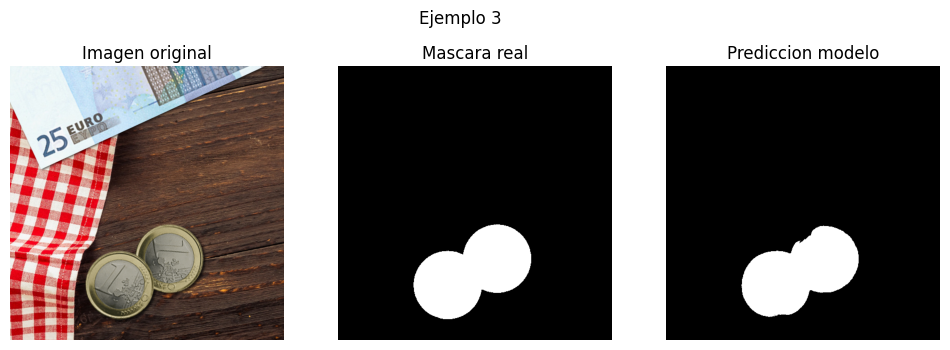

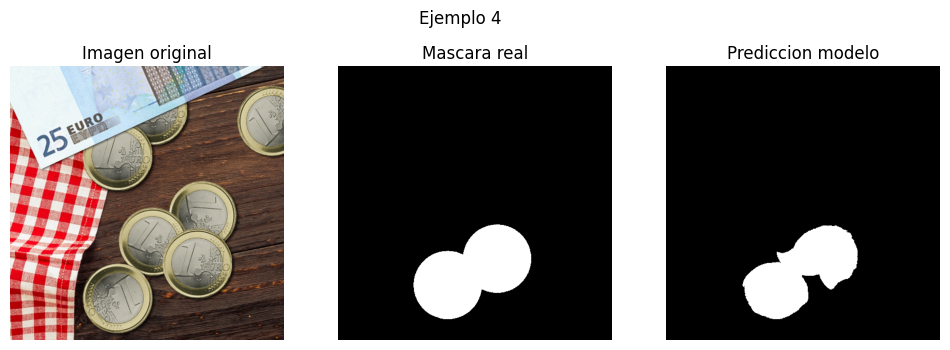

In [8]:
visualize_prediction(ablated_1, ds_loader)

In [9]:
iou_score = intersection_over_union(ablated_1, ds_loader, device)
print(f"Puntuacion IoU del modelo actual: {iou_score:.4f}")

C:\Users\fabio\AppData\Local\Temp\ipykernel_18168\3170726975.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\fabio\AppData\Local\Temp\ipykernel_18168\3170726975.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Puntuacion IoU del modelo actual: 0.9414


# Skip 1 y 2

In [10]:
ablated_1_2 = build_unet(f_start=64, skips=[False, False, True, True]).to(device)
train(ablated_1_2, n_epochs=100)

C:\Users\fabio\AppData\Local\Temp\ipykernel_18168\3170726975.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\fabio\AppData\Local\Temp\ipykernel_18168\3170726975.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Lote: 0
Epoch [1/100], Loss: 0.2082
Lote: 0
Epoch [2/100], Loss: 0.5437
Lote: 0
Epoch [3/100], Loss: 0.1265
Lote: 0
Epoch [4/100], Loss: 0.1017
Lote: 0
Epoch [5/100], Loss: 0.0841
Lote: 0
Epoch [6/100], Loss: 0.0737
Lote: 0
Epoch [7/100], Loss: 0.0648
Lote: 0
Epoch [8/100], Loss: 0.0610
Lote: 0
Epoch [9/100], Loss: 0.0589
Lote: 0
Epoch [10/100], Loss: 0.0555
Lote: 0
Epoch [11/100], Loss: 0.0523
Lote: 0
Epoch [12/100], Loss: 0.0496
Lote: 0
Epoch [13/100], Loss: 0.0478
Lote: 0
Epoch [14/100], Loss: 0.0464
Lote: 0
Epoch [15/100], Loss: 0.0444
Lote: 0
Epoch [16/100], Loss: 0.0419
Lote: 0
Epoch [17/100], Loss: 0.0398
Lote: 0
Epoch [18/100], Loss: 0.0389
Lote: 0
Epoch [19/100], Loss: 0.0383
Lote: 0
Epoch [20/100], Loss: 0.0373
Lote: 0
Epoch [21/100], Loss: 0.0365
Lote: 0
Epoch [22/100], Loss: 0.0359
Lote: 0
Epoch [23/100], Loss: 0.0356
Lote: 0
Epoch [24/100], Loss: 0.0355
Lote: 0
Epoch [25/100], Loss: 0.0352
Lote: 0
Epoch [26/100], Loss: 0.0345
Lote: 0
Epoch [27/100], Loss: 0.0339
Lote: 0
Ep

C:\Users\fabio\AppData\Local\Temp\ipykernel_18168\3170726975.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\fabio\AppData\Local\Temp\ipykernel_18168\3170726975.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


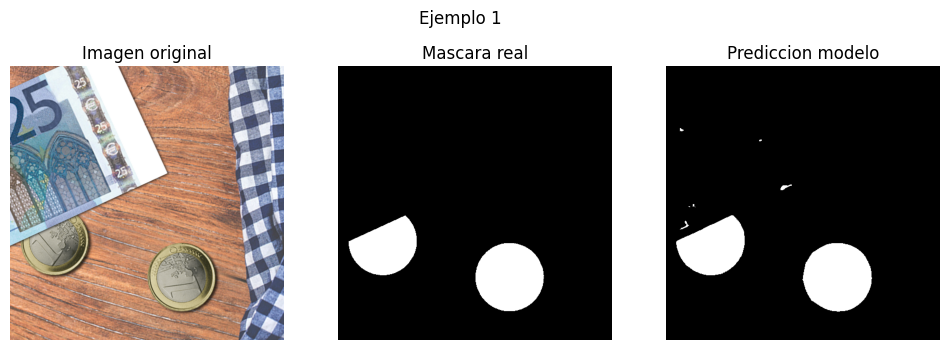

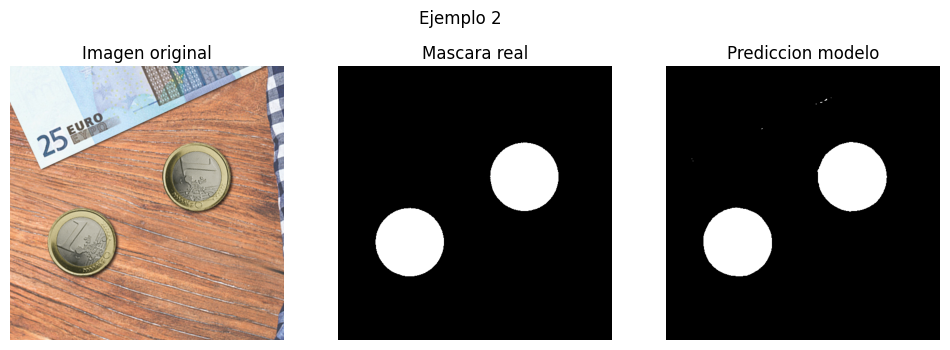

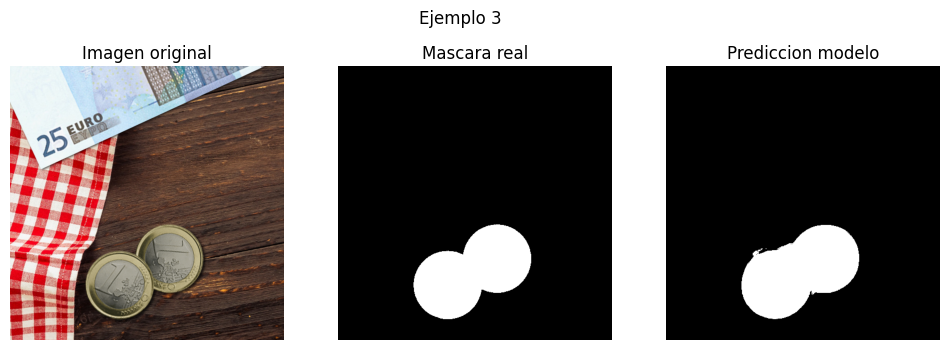

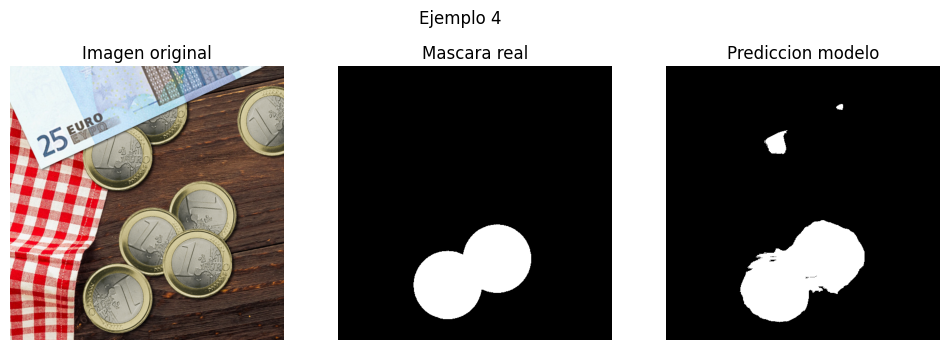

In [11]:
visualize_prediction(ablated_1_2, ds_loader)

In [12]:
iou_score = intersection_over_union(ablated_1_2, ds_loader, device)
print(f"Puntuacion IoU del modelo actual: {iou_score:.4f}")

C:\Users\fabio\AppData\Local\Temp\ipykernel_18168\3170726975.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\fabio\AppData\Local\Temp\ipykernel_18168\3170726975.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Puntuacion IoU del modelo actual: 0.9393


# Skip 1, 2 y 3

In [13]:
ablated_1_2_3 = build_unet(f_start=64, skips=[False, False, False, True]).to(device)
train(ablated_1_2_3, n_epochs=100)

C:\Users\fabio\AppData\Local\Temp\ipykernel_18168\3170726975.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\fabio\AppData\Local\Temp\ipykernel_18168\3170726975.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Lote: 0
Epoch [1/100], Loss: 0.2146
Lote: 0
Epoch [2/100], Loss: 0.5622
Lote: 0
Epoch [3/100], Loss: 0.1332
Lote: 0
Epoch [4/100], Loss: 0.1193
Lote: 0
Epoch [5/100], Loss: 0.0905
Lote: 0
Epoch [6/100], Loss: 0.0721
Lote: 0
Epoch [7/100], Loss: 0.0642
Lote: 0
Epoch [8/100], Loss: 0.0632
Lote: 0
Epoch [9/100], Loss: 0.0573
Lote: 0
Epoch [10/100], Loss: 0.0502
Lote: 0
Epoch [11/100], Loss: 0.0466
Lote: 0
Epoch [12/100], Loss: 0.0433
Lote: 0
Epoch [13/100], Loss: 0.0379
Lote: 0
Epoch [14/100], Loss: 0.0334
Lote: 0
Epoch [15/100], Loss: 0.0511
Lote: 0
Epoch [16/100], Loss: 0.0427
Lote: 0
Epoch [17/100], Loss: 0.0365
Lote: 0
Epoch [18/100], Loss: 0.0385
Lote: 0
Epoch [19/100], Loss: 0.0371
Lote: 0
Epoch [20/100], Loss: 0.0313
Lote: 0
Epoch [21/100], Loss: 0.0266
Lote: 0
Epoch [22/100], Loss: 0.0245
Lote: 0
Epoch [23/100], Loss: 0.0238
Lote: 0
Epoch [24/100], Loss: 0.0231
Lote: 0
Epoch [25/100], Loss: 0.0195
Lote: 0
Epoch [26/100], Loss: 0.0168
Lote: 0
Epoch [27/100], Loss: 0.0169
Lote: 0
Ep

C:\Users\fabio\AppData\Local\Temp\ipykernel_18168\3170726975.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\fabio\AppData\Local\Temp\ipykernel_18168\3170726975.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


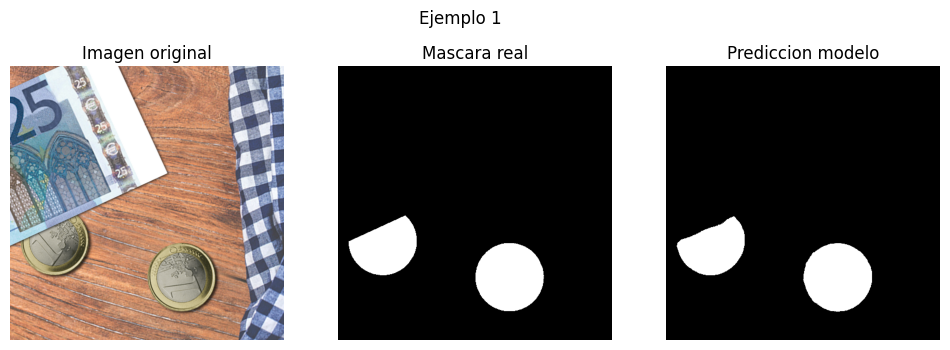

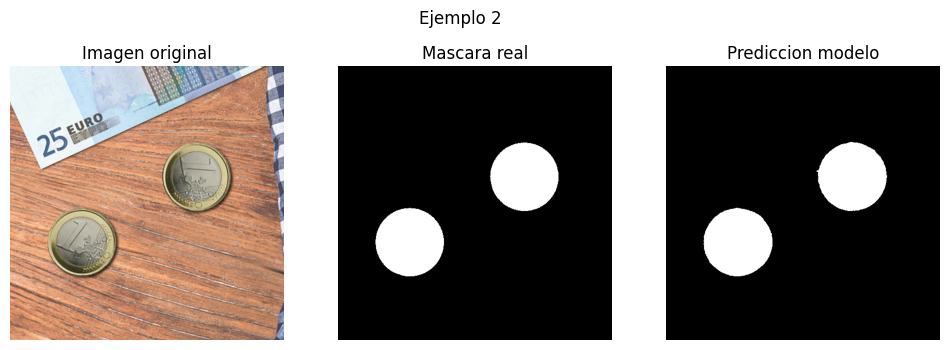

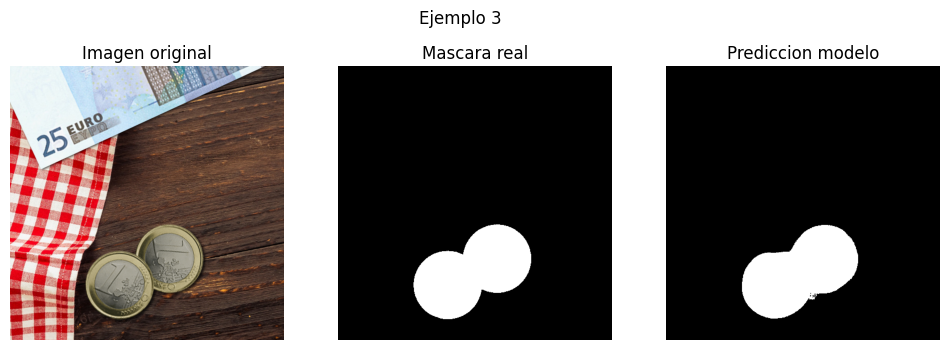

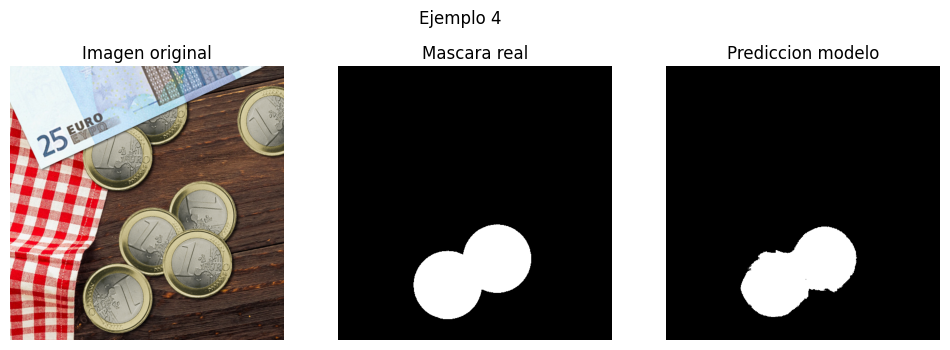

In [14]:
visualize_prediction(ablated_1_2_3, ds_loader)

In [15]:
iou_score = intersection_over_union(ablated_1_2_3, ds_loader, device)
print(f"Puntuacion IoU del modelo actual: {iou_score:.4f}")

C:\Users\fabio\AppData\Local\Temp\ipykernel_18168\3170726975.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\fabio\AppData\Local\Temp\ipykernel_18168\3170726975.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Puntuacion IoU del modelo actual: 0.9568


# Skip All

In [19]:
ablated_all = build_unet(f_start=64, skips=[False, False, False, False]).to(device)
train(ablated_all, n_epochs=100)

C:\Users\fabio\AppData\Local\Temp\ipykernel_18168\3170726975.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\fabio\AppData\Local\Temp\ipykernel_18168\3170726975.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Lote: 0
Epoch [1/100], Loss: 0.2111
Lote: 0
Epoch [2/100], Loss: 0.5507
Lote: 0
Epoch [3/100], Loss: 0.1458
Lote: 0
Epoch [4/100], Loss: 0.1337
Lote: 0
Epoch [5/100], Loss: 0.1079
Lote: 0
Epoch [6/100], Loss: 0.0948
Lote: 0
Epoch [7/100], Loss: 0.0871
Lote: 0
Epoch [8/100], Loss: 0.0853
Lote: 0
Epoch [9/100], Loss: 0.0866
Lote: 0
Epoch [10/100], Loss: 0.0869
Lote: 0
Epoch [11/100], Loss: 0.0859
Lote: 0
Epoch [12/100], Loss: 0.0849
Lote: 0
Epoch [13/100], Loss: 0.0843
Lote: 0
Epoch [14/100], Loss: 0.0842
Lote: 0
Epoch [15/100], Loss: 0.0843
Lote: 0
Epoch [16/100], Loss: 0.0845
Lote: 0
Epoch [17/100], Loss: 0.0846
Lote: 0
Epoch [18/100], Loss: 0.0845
Lote: 0
Epoch [19/100], Loss: 0.0841
Lote: 0
Epoch [20/100], Loss: 0.0836
Lote: 0
Epoch [21/100], Loss: 0.0832
Lote: 0
Epoch [22/100], Loss: 0.0831
Lote: 0
Epoch [23/100], Loss: 0.0832
Lote: 0
Epoch [24/100], Loss: 0.0834
Lote: 0
Epoch [25/100], Loss: 0.0834
Lote: 0
Epoch [26/100], Loss: 0.0833
Lote: 0
Epoch [27/100], Loss: 0.0831
Lote: 0
Ep

C:\Users\fabio\AppData\Local\Temp\ipykernel_18168\3170726975.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\fabio\AppData\Local\Temp\ipykernel_18168\3170726975.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


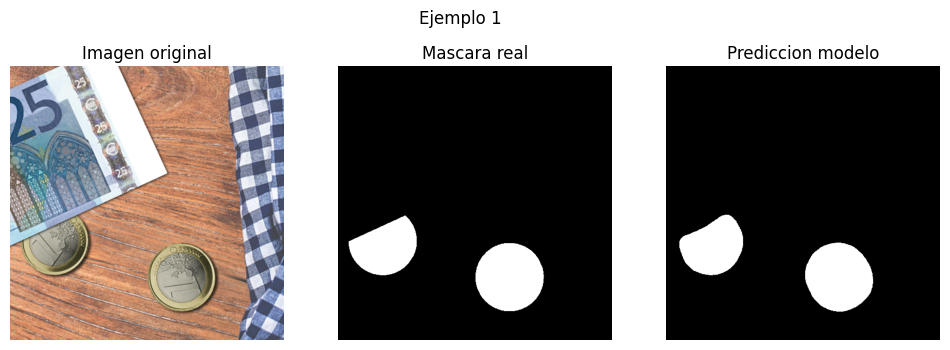

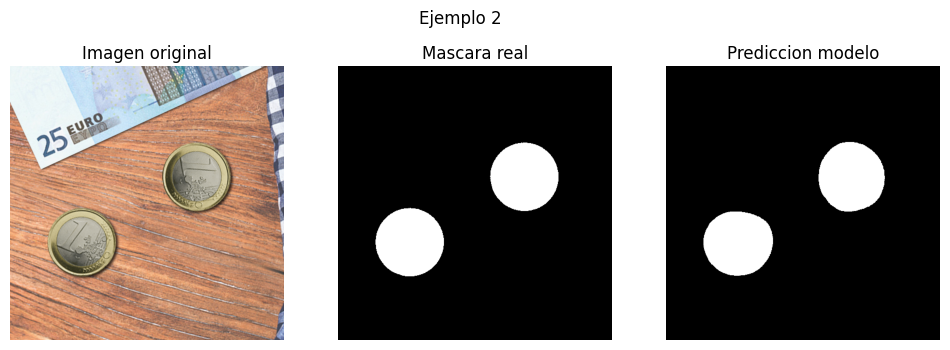

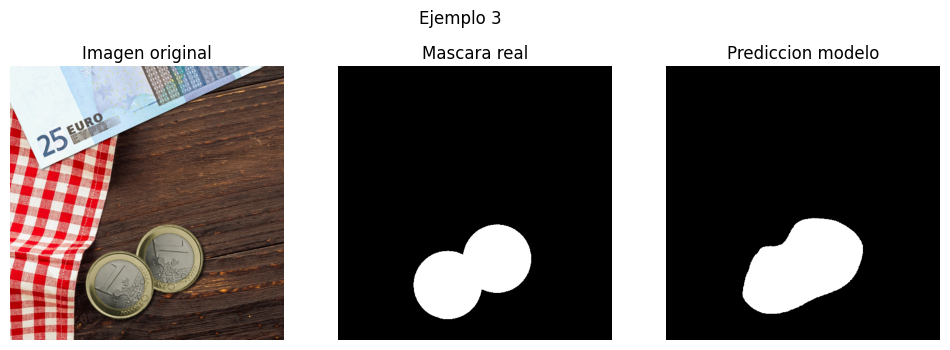

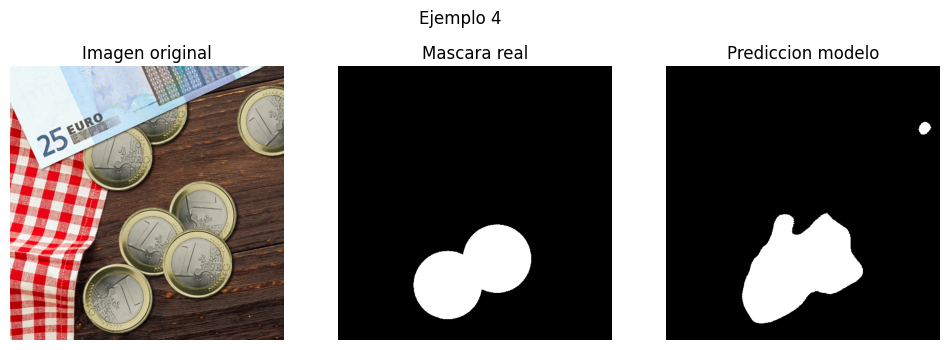

In [20]:
visualize_prediction(ablated_all, ds_loader)

In [21]:
iou_score = intersection_over_union(ablated_all, ds_loader, device)
print(f"Puntuacion IoU del modelo actual: {iou_score:.4f}")

C:\Users\fabio\AppData\Local\Temp\ipykernel_18168\3170726975.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\fabio\AppData\Local\Temp\ipykernel_18168\3170726975.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Puntuacion IoU del modelo actual: 0.8634
